In [2]:
#python libraries
import os
import re

#other ML libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", "Temperature"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True).dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)

            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)

            if measurement_type  == "Temperature":
                measurement_frame  = measurement_frame.resample('5T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..
                sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  
    

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()


In [23]:
sensor_data.loc[sensor_data.index.month == 7]

,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,1Entrance1_temperature,1Entrance2_temperature,1GuestRoom_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,1StairBottom_temperature,2BalconyEntrance_temperature,2Cooking_temperature,2Fireplace_temperature,2LRWindow_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature,2Stair_temperature
timestamp,,,,,,,,,,,,,,,,
2022-07-01 00:00:00+02:00,25.250000,23.100,21.700000,25.300000,13.45,25.016667,25.400000,21.333333,24.10,26.80,27.983333,27.133333,27.300,27.150,27.025,26.30
2022-07-01 00:05:00+02:00,25.200000,23.250,21.683333,25.300000,13.45,25.033333,25.400000,21.316667,24.10,26.85,27.966667,27.200000,27.350,27.100,27.050,26.40
2022-07-01 00:10:00+02:00,25.150000,23.200,21.666667,25.300000,13.45,25.050000,25.350000,21.300000,24.10,26.90,27.950000,27.233333,27.450,27.100,27.050,26.55
2022-07-01 00:15:00+02:00,25.116667,23.200,21.650000,25.300000,13.45,25.033333,25.300000,21.250000,24.15,27.00,27.916667,27.266667,27.300,27.150,27.150,26.45
2022-07-01 00:20:00+02:00,25.083333,23.200,21.683333,25.300000,13.45,25.016667,25.250000,21.200000,24.10,27.00,27.883333,27.300000,27.400,27.125,27.150,26.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 23:35:00+02:00,21.566667,20.450,19.100000,22.766667,13.45,22.683333,20.533333,12.250000,21.65,23.65,24.183333,23.833333,23.850,23.550,24.000,23.65
2022-07-31 23:40:00+02:00,21.600000,20.500,19.100000,22.800000,13.45,22.700000,20.550000,12.200000,21.70,23.70,24.150000,23.800000,23.750,23.500,24.300,23.60
2022-07-31 23:45:00+02:00,21.600000,20.500,19.116667,22.733333,13.45,22.700000,20.516667,12.150000,21.65,23.70,24.100000,23.783333,23.650,23.450,24.200,23.60


array([[<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,
        <AxesSubplot: xlabel='timestamp'>],
       [<AxesSubplot: xlabel='timestamp'>,


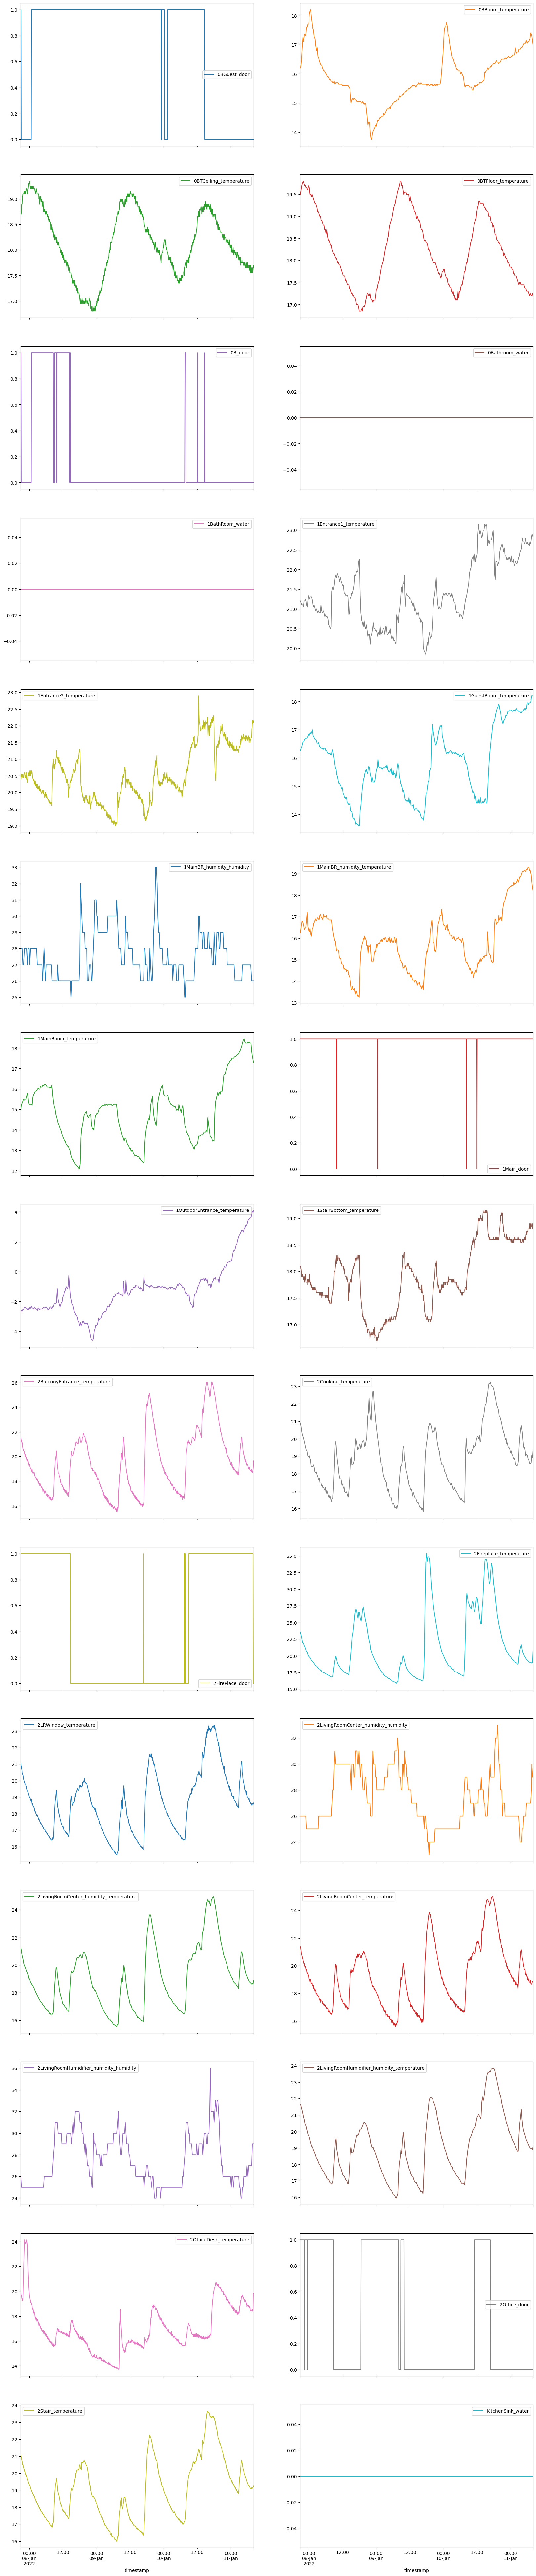

In [5]:
#Saving sensor_data plot to sensor_data.pdf
sensor_data.head(1000).plot(subplots=True, layout=(15, 2), figsize=(20, 100))

In [5]:
print(f"Shape of DataFrame: {sensor_data.shape}")
sensor_data.head(2)

Shape of DataFrame: (67961, 30)


,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1Entrance2_temperature,1GuestRoom_temperature,...,2LRWindow_temperature,2LivingRoomCenter_humidity_humidity,2LivingRoomCenter_humidity_temperature,2LivingRoomCenter_temperature,2LivingRoomHumidifier_humidity_humidity,2LivingRoomHumidifier_humidity_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,KitchenSink_water
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-07 20:50:00+01:00,1.0,16.2,18.65,19.5,1.0,0.0,0.0,21.2,20.500,16.25,...,20.95,26.0,21.3,21.40,26.0,21.65,19.80,1.0,21.15,0.0
2022-01-07 20:55:00+01:00,1.0,16.2,18.70,19.5,1.0,0.0,0.0,21.2,20.525,16.25,...,20.95,26.0,21.3,21.35,26.0,21.65,19.75,1.0,21.15,0.0
